In [1]:
import pandas as pd
import chart_studio
chart_studio.tools.set_credentials_file(username='username', api_key='api_key')
import chart_studio.plotly as py
import plotly.express as px
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import *

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # For creating plots
import matplotlib.ticker as mtick # For specifying the axes tick format 
import matplotlib.pyplot as plt

In [2]:
#파일 불러오기
file_path = '../Churn.xlsx'
data = pd.read_excel(file_path)

In [3]:
data.head()

,Age,Number of Dependents,Membership,Satisfaction Score,Tech services,Streaming services,Combined Product,Contract,Tenure in Months,Monthly Charge,Total Revenue,Churn Value
0,78,0,None,3,1,1,2,Month-to-Month,1,39.65,59.65,1
1,74,1,Offer E,3,1,0,1,Month-to-Month,8,80.65,1024.10,1
2,71,3,Offer D,2,0,2,1,Month-to-Month,18,95.45,1910.88,1
3,78,1,Offer C,2,2,2,1,Month-to-Month,25,98.50,2995.07,1
4,80,1,Offer C,2,0,0,1,Month-to-Month,37,76.50,3102.36,1


In [4]:
#범주형 문자화
data['Satisfaction Score'] = data['Satisfaction Score'].astype(str)

#더미 변수화
d_data = pd.get_dummies(data)

d_data.head()

,Age,Number of Dependents,Tech services,Streaming services,Combined Product,Tenure in Months,Monthly Charge,Total Revenue,Churn Value,Membership_None,...,Membership_Offer D,Membership_Offer E,Satisfaction Score_1,Satisfaction Score_2,Satisfaction Score_3,Satisfaction Score_4,Satisfaction Score_5,Contract_Month-to-Month,Contract_One Year,Contract_Two Year
0,78,0,1,1,2,1,39.65,59.65,1,1,...,0,0,0,0,1,0,0,1,0,0
1,74,1,1,0,1,8,80.65,1024.10,1,0,...,0,1,0,0,1,0,0,1,0,0
2,71,3,0,2,1,18,95.45,1910.88,1,0,...,1,0,0,1,0,0,0,1,0,0
3,78,1,2,2,1,25,98.50,2995.07,1,0,...,0,0,0,1,0,0,0,1,0,0
4,80,1,0,0,1,37,76.50,3102.36,1,0,...,0,0,0,1,0,0,0,1,0,0


In [5]:
# Churn Value 열을 타겟 변수로 설정. 종속 변수와 독립 변수 분리
y = d_data['Churn Value'].values
X = d_data.drop(columns=['Churn Value'])


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler


#MinMax 스케일링
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

#로버스트
#scaler = RobustScaler().fit(X_train)
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)




In [7]:
# 학습 및 테스트 데이터 분리
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=88)


In [8]:
# SMOTE 오버샘플링
over = SMOTE(sampling_strategy='auto', random_state=88)
X_train_resampled, y_train_resampled = over.fit_resample(X_train_scaled, y_train)

print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_scaled.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_resampled.shape, y_train_resampled.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_resampled).value_counts())


SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (7043, 22) (4930,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (7220, 22) (7220,)
SMOTE 적용 후 레이블 값 분포: 
 0    3610
1    3610
dtype: int64


In [9]:
print(X_train_scaled)
print(X_train_scaled[0])

[[0.42622951 0.         0.5        ... 0.         1.         0.        ]
 [0.68852459 0.         0.         ... 1.         0.         0.        ]
 [0.1147541  0.         0.5        ... 0.         0.         1.        ]
 ...
 [0.57377049 0.         0.75       ... 1.         0.         0.        ]
 [0.29508197 0.         0.5        ... 0.         0.         1.        ]
 [0.60655738 0.33333333 0.         ... 1.         0.         0.        ]]
[0.42622951 0.         0.5        0.         0.33333333 0.94366197
 0.360199   0.40453906 0.         1.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         1.         0.        ]


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# 로지스틱 회귀 모델 튜닝
lr_model = LogisticRegression(random_state=88, max_iter=1000)

# 하이퍼파라미터 그리드 설정
param_grid = {
    'penalty': ['l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

# GridSearchCV를 사용한 하이퍼파라미터 튜닝
grid_search = GridSearchCV(lr_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_resampled, y_train_resampled)

# 최적 하이퍼파라미터 출력
print("로지스틱 회귀 모델 최적 하이퍼파라미터:", grid_search.best_params_)

# 최적 모델로 재학습
best_lr_model = grid_search.best_estimator_
best_lr_model.fit(X_train_resampled, y_train_resampled)

# 테스트 데이터로 성능 평가
y_pred_lr = best_lr_model.predict(X_test_scaled)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
confusion_lr = confusion_matrix(y_test, y_pred_lr)
report_lr = classification_report(y_test, y_pred_lr)

y_prob_lr = best_lr_model.predict_proba(X_test_scaled)
roc_auc = roc_auc_score(y_test, y_prob_lr[:, 1])

print("로지스틱 회귀 모델 정확도:", accuracy_lr)
print("로지스틱 회귀 모델 혼동 행렬:\n", confusion_lr)
print("로지스틱 회귀 모델 분류 보고서:\n", report_lr)
print("ROC-AUC:", roc_auc)

로지스틱 회귀 모델 최적 하이퍼파라미터: {'C': 100, 'penalty': 'l2'}
로지스틱 회귀 모델 정확도: 0.9403691433980123
로지스틱 회귀 모델 혼동 행렬:
 [[1464  100]
 [  26  523]]
로지스틱 회귀 모델 분류 보고서:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96      1564
           1       0.84      0.95      0.89       549

    accuracy                           0.94      2113
   macro avg       0.91      0.94      0.93      2113
weighted avg       0.95      0.94      0.94      2113

ROC-AUC: 0.9897453635766494


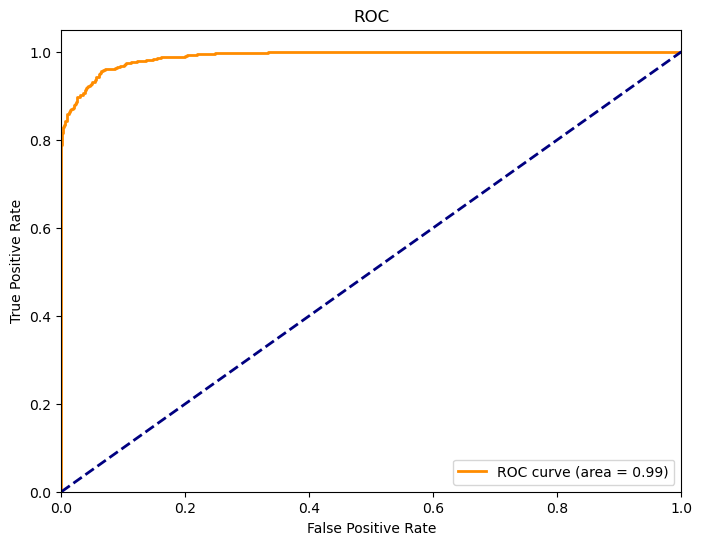

In [11]:
# ROC 곡선 그리기
y_score_lr = best_lr_model.decision_function(X_test_scaled)  # 로지스틱 회귀의 결정 함수 값
fpr, tpr, _ = roc_curve(y_test, y_score_lr)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc='lower right')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


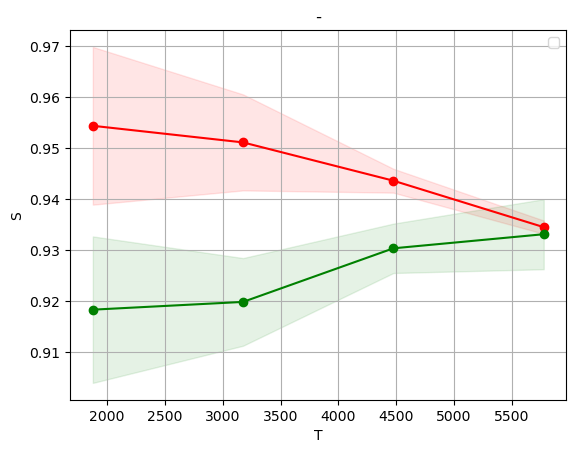

In [12]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# 모델과 데이터를 사용하여 학습 곡선 그리기
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("T")
    plt.ylabel("S")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",)

    plt.legend(loc="best")
    return plt

# 학습 곡선 그리기
plot_learning_curve(best_lr_model,'-' , X_train_resampled, y_train_resampled, cv=5, n_jobs=4)

plt.show()